# The BioPlex protein-protein interactions data set

## Import packages

In [37]:
''' Python packages '''
import numpy as np
from matplotlib import pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE

''' Project specific tools '''
from data_management import *
from models import *
from display import *
from metrics import *

''' Display configs '''
%matplotlib inline

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset description

In [39]:
data_man = DataManager('BioPlex_PU_data.pkl')
P, U, _, _ = data_man.parse_pickle()

In [40]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, normalize=True)
X_norm = np.concatenate((x_train, x_test))
fig = FigureDrawer('Feature distributions')
fig.draw_hist_array(X_norm.T, labels=data_man.feature_labels)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


TypeError: __init__() missing 1 required positional argument: 'figsize'

### Visualize data with dimensionality reduction

In [41]:
x_train, t_train, _, _ = data_man.split_training_test(P, U, test_size=0.03, PU_ratio=8., normalize=True, show_counts=True)
tsne = TSNE(n_jobs=6, perplexity=40, learning_rate=20, early_exaggeration=12, n_iter=5000) # n_iter=2000

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


ValueError: train_size=354560 should be smaller than the number of samples 325533

In [ ]:
x_8d = np.delete(x_train, [1,], axis=1)
x_7d = np.delete(x_train, [1,8], axis=1)

X_9d_embedded = tsne.fit_transform(x_train)[::-1]
X_8d_embedded = tsne.fit_transform(x_8d)[::-1]
X_7d_embedded = tsne.fit_transform(x_7d)[::-1]

In [ ]:
x_tsne = (
    np.concatenate((X_9d_embedded, t_train[:,np.newaxis][::-1]), axis=1),
    np.concatenate((X_8d_embedded, t_train[:,np.newaxis][::-1]), axis=1), 
    np.concatenate((X_7d_embedded, t_train[:,np.newaxis][::-1]), axis=1), 
)

In [ ]:
# remove
import pickle
pickle.dump(x_tsne, open('tsne.pkl', 'wb'))
x_tsne = pickle.load(open('tsne.pkl', 'rb'))

In [ ]:
fig = FigureDrawer('T-SNE visualisation')
fig.draw_scatter_plot(x_tsne, titles=['9D', '8D', '7D'], figsize=(14,6))

## Polynomial basis function and linear classifier

In [42]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.5, PU_ratio=1., normalize=True)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [43]:
lm = Model('linear', C=1, M=6, max_iter=5000)

In [44]:
lm.hyperpar_tuning(x_train, t_train)

{'C': 2, 'M': 3}

In [45]:
lm.train(x_train, t_train)

In [46]:
t_pred = lm.predict(x_test)

In [47]:
metrics = Metrics()

In [48]:
metrics.accuracy(t_pred, t_test)

0.8353167411084557

In [49]:
metrics.recall(t_pred, t_test)

0.47802678805917886

In [50]:
metrics.LL_score(t_pred, t_test)

1.4140525304148095

## Multi Layer Perceptron

In [51]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.5, PU_ratio=5., normalize=True)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [52]:
mlp = Model('MLP', max_iter=2000)

In [53]:
mlp.train(x_train, t_train)

In [54]:
t_pred = mlp.predict(x_test)

In [55]:
t_pred_proba = mlp.predict(x_test, proba=True)

In [56]:
metrics = Metrics()

In [57]:
curve = metrics.rc_ll_curve(t_pred_proba, t_test)

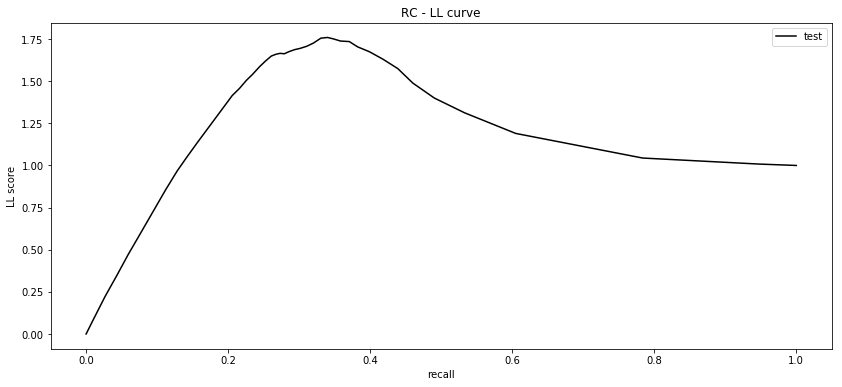

In [58]:
fig = FigureDrawer('RC - LL curve', figsize=(14,6))
fig.draw_line_plot(lines=[curve, ], 
                   colors=['k',], 
                   labels=['test',], 
                   x_lab='recall', y_lab='LL score')

In [67]:
scores = []
for n in range(10, 105, 5):
    mlp = Model('MLP', n_neurons=n, n_layers=4, max_iter=2000)
    mlp.train(x_train, t_train)
    t_pred = mlp.predict(x_test)
    scores.append((n, metrics.recall(t_pred, t_test), metrics.LL_score(t_pred, t_test)))

Where am i
Before training
After training


In [ ]:
pickle.dump(scores, open('scores.pkl', 'wb'))

In [ ]:
import pickle
scores = pickle.load(open('scores.pkl', 'rb'))

In [ ]:
fig = FigureDrawer('varying number of neurons', figsize=(14,6))
fig.draw_line_plot(np.array(scores)[:,0], np.array(scores)[:,2], x_lab='# neurons', y_lab='LL score')

In [ ]:
scores = []
for n in range(1, 11):
    mlp = Model('MLP', n_neurons=20, n_layers=n, max_iter=2000)
    mlp.train(x_train, t_train)
    t_pred = mlp.predict(x_test)
    scores.append((n, metrics.recall(t_pred, t_test), metrics.LL_score(t_pred, t_test)))

In [ ]:
fig = FigureDrawer('varying number of layers', figsize=(14,6))
fig.draw_line_plot(np.array(scores)[:,0], np.array(scores)[:,2], x_lab='# layers', y_lab='LL score')

In [ ]:
np.array(scores)[:,1]

In [ ]:
metrics.accuracy(t_pred, t_test)

In [ ]:
metrics.recall(t_pred, t_test)

## Support Vector Machines 

In [ ]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.90, normalize=True)

### Radial Basis Funtion Kernel

In [ ]:
svm_rbf = Model('SVM', kernel='rbf', C=3, gamma=105.)

In [ ]:
svm_rbf.hyperpar_tuning(x_train, t_train)

In [ ]:
svm_rbf.train(x_train, t_train)

In [ ]:
t_pred_proba = svm_rbf.predict(x_test, proba=True)

In [ ]:
metrics = Metrics()

In [ ]:
svm_rbf_curve = metrics.rc_ll_curve(t_pred_proba, t_test)

In [ ]:
fig = FigureDrawer('RC - LL curve', figsize=(14,6))
fig.draw_line_plot(lines=[svm_rbf_curve, ], 
                   colors=['k',], 
                   labels=['SVM - RBF',], 
                   x_lab='recall', y_lab='LL score')

### Sigmoidal Kernel

In [ ]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.95, normalize=True)

In [ ]:
svm_sig = Model('SVM', kernel='sigmoid')

In [ ]:
svm_sig.train(x_train, t_train)

In [ ]:
t_pred_proba = svm_sig.predict(x_test, proba=True)

In [ ]:
svm_sig_curve = metrics.rc_ll_curve(t_pred_proba, t_test)

In [ ]:
fig = FigureDrawer('RC - LL curve', figsize=(14,6))
fig.draw_line_plot(lines=[svm_rbf_curve, svm_sig_curve], 
                   colors=['k', 'b'], 
                   labels=['SVM - RBF', 'SVM - SIG'], 
                   x_lab='recall', y_lab='LL score')

## Model Ensembles

### SVM ensemble

In [68]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.3, normalize=True, show_counts=True)

len P_train: 31983
len P_test: 13708
len U_train: 15991
len U_test: 309542
 nP/nU: 2.0000625351760366
len x_train: 47974
len x_test: 323250
nTest/total 0.8707680537896256


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [83]:
svm_ens = Ensemble('SVM',  hyperpars={'kernel':'rbf', 'C': 3, 'gamma': 105.}, M=10)

In [84]:
svm_ens.bagging_train(x_train, t_train)

In [85]:
metrics = Metrics()

In [86]:
t_pred_proba = svm_ens.predict(x_test, proba=True)

In [87]:
bagging_curve = metrics.rc_ll_curve( t_pred_proba, t_test)

In [88]:
svm_array_curves = []
for m in np.random.choice(svm_ens.model_array, 5):
    t_pred_proba = m.predict(x_test, proba=True)
    svm_array_curves.append(metrics.rc_ll_curve(t_pred_proba, t_test))

KeyboardInterrupt: 

In [ ]:
fig = FigureDrawer('RC - LL curve', figsize=(14,6))
fig.draw_line_plot(lines=[bagging_curve, ], 
                   colors=['k', ], 
                   labels=['Bagging SVMs', ], 
                   x_lab='recall', y_lab='LL score')

In [ ]:
fig = FigureDrawer('RC - LL curve', figsize=(14,6))
fig.draw_line_plot(lines=[bagging_curve, *svm_array_curves], 
                   colors=['k', *('g',)*5], 
                   labels=['Bagging SVMs', *('array model',)*5], 
                   x_lab='recall', y_lab='LL score')

### MLP ensemble

In [ ]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.3, normalize=True)

In [ ]:
mlp_ens = Ensemble('MLP', hyperpars={'max_iter':2000}, M=10)

In [ ]:
mlp_ens.bagging_train(x_train, t_train)

In [ ]:
t_pred_proba = mlp_ens.predict(x_test, proba=True)

In [ ]:
mlp_array_curves = []
for m in np.random.choice(svm_ens.model_array, 5):
    t_pred_proba = m.predict(x_test, proba=True)
    svm_array_curves.append(metrics.rc_ll_curve(t_pred_proba, t_test))

In [ ]:
for m in ann_ens.model_array:
    t_pred = m.predict(x_test)
    print(metrics.LL_score(t_pred, t_test))

# Random forest


In [129]:
x_train, t_train, x_test, t_test = data_man.split_training_test(P, U, test_size=0.3, normalize=True)

rfm = Model('MLP')
trained = rfm.train(x_train, t_train)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [130]:
t_pred = rfm.predict(x_test)

In [131]:
metrics = Metrics()

In [132]:
metrics.accuracy(t_pred, t_test)

0.18950038669760247

In [133]:
metrics.recall(t_pred, t_test)

0.929092500729501

In [134]:
metrics.LL_score(t_pred, t_test)

1.0192708955180803

Itr
Itr
Itr
Itr
Itr
Itr
Itr
Itr
Itr
Itr


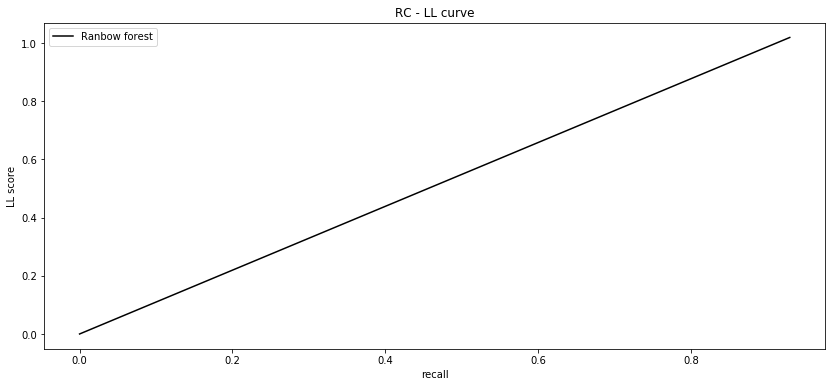

In [141]:
curve = metrics.rc_ll_curve(t_pred, t_test, iterations = 10)
fig = FigureDrawer('RC - LL curve', figsize=(14,6))
fig.draw_line_plot(lines=[curve, ], 
                   colors=['k',], 
                   labels=['Ranbow forest',], 
                   x_lab='recall', y_lab='LL score')

## Compare models

10 fold cross validation